In [1]:
%reset -f
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import plotly
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas_profiling import ProfileReport
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
engine = create_engine("sqlite:////Users/nathanieldirenzo/Documents/GitHub/NBM_EDA_Student/resources/get_mta/mta_data.db")

In [3]:
df = pd.read_sql('SELECT * FROM mta_data LIMIT 250000;', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [4]:
#profile = ProfileReport(df)
#profile

In [5]:
df = df.rename(columns={'C/A': 'control_area', 'UNIT': 'unit', 'SCP': 'subunit_channel_pos', 'STATION':'station', 'LINENAME':'subway_lines', 'DIVISION':'division', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 'ENTRIES':'entries', 'EXITS':'exits'})

In [6]:
df.head()

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [7]:
df['date'] = df['date'].str.replace('/','_')
df['time'] = df['time'].str.replace(':','_')
df['desc'] = df['desc'].str.replace(' ', '_')
df['subunit_channel_pos'] = df['subunit_channel_pos'].str.replace('-', '_')
df['station'] = df['station'].str.replace('-', '_')
df['station'] = df['station'].str.replace(' ', '_')
df['station'] = df['station'].str.replace('/','_')

In [8]:
df['unique_id'] = df['control_area'] + '_' + df['unit'] + '_' + df['subunit_channel_pos'] + '_' + df['station'] + '_' + df['date'] + '_' + df['time'] + '_' + df['desc']

In [9]:
df = df.set_index('unique_id')

In [10]:
df['date_time'] = df.date + ' ' + df.time

In [11]:
df.date_time = pd.to_datetime(df['date_time'], format = '%m_%d_%Y %H_%M_%S')

In [12]:
df.sample(20)

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time
unique_id,,,,,,,,,,,,
K025_R404_00_03_03_FRESH_POND_RD_12_21_2021_08_00_00_REGULAR,K025,R404,00_03_03,FRESH_POND_RD,M,BMT,12_21_2021,08_00_00,REGULAR,80757,53406,2021-12-21 08:00:00
N141_R356_00_00_03_OZONE_PK_LEFFRT_12_23_2021_11_00_00_REGULAR,N141,R356,00_00_03,OZONE_PK_LEFFRT,A,IND,12_23_2021,11_00_00,REGULAR,4013323,3987136,2021-12-23 11:00:00
R132_R190_01_00_03_23_ST_12_23_2021_04_00_00_REGULAR,R132,R190,01_00_03,23_ST,1,IRT,12_23_2021,04_00_00,REGULAR,214168,692708,2021-12-23 04:00:00
A042_R086_01_00_02_PRINCE_ST_12_24_2021_15_00_00_REGULAR,A042,R086,01_00_02,PRINCE_ST,NRW,BMT,12_24_2021,15_00_00,REGULAR,2232833,2808589,2021-12-24 15:00:00
R158_R084_00_05_03_59_ST_COLUMBUS_12_24_2021_11_00_00_REGULAR,R158,R084,00_05_03,59_ST_COLUMBUS,1ABCD,IRT,12_24_2021,11_00_00,REGULAR,1458,0,2021-12-24 11:00:00
N503_R021_00_00_04_42_ST_BRYANT_PK_12_19_2021_03_00_00_REGULAR,N503,R021,00_00_04,42_ST_BRYANT_PK,BDFM7,IND,12_19_2021,03_00_00,REGULAR,5805650,4514759,2021-12-19 03:00:00
N182_R414_00_00_01_HOWARD_BCH_JFK_12_20_2021_07_00_00_REGULAR,N182,R414,00_00_01,HOWARD_BCH_JFK,A,IND,12_20_2021,07_00_00,REGULAR,1865085,147303,2021-12-20 07:00:00
H017_R265_00_00_01_MONTROSE_AV_12_24_2021_03_00_00_REGULAR,H017,R265,00_00_01,MONTROSE_AV,L,BMT,12_24_2021,03_00_00,REGULAR,3709677,1964683,2021-12-24 03:00:00
PTH07_R550_00_00_00_CITY___BUS_12_18_2021_19_40_29_REGULAR,PTH07,R550,00_00_00,CITY___BUS,1,PTH,12_18_2021,19_40_29,REGULAR,186857,164069,2021-12-18 19:40:29


In [13]:
df[df.desc == 'RECOVR_AUD']

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time
unique_id,,,,,,,,,,,,
A033_R170_02_00_00_14_ST_UNION_SQ_12_20_2021_16_00_00_RECOVR_AUD,A033,R170,02_00_00,14_ST_UNION_SQ,LNQR456W,BMT,12_20_2021,16_00_00,RECOVR_AUD,425175,1467688,2021-12-20 16:00:00
A033_R170_02_00_00_14_ST_UNION_SQ_12_20_2021_20_00_00_RECOVR_AUD,A033,R170,02_00_00,14_ST_UNION_SQ,LNQR456W,BMT,12_20_2021,20_00_00,RECOVR_AUD,425283,1468035,2021-12-20 20:00:00
A033_R170_02_00_01_14_ST_UNION_SQ_12_20_2021_16_00_00_RECOVR_AUD,A033,R170,02_00_01,14_ST_UNION_SQ,LNQR456W,BMT,12_20_2021,16_00_00,RECOVR_AUD,2692260,3446144,2021-12-20 16:00:00
A033_R170_02_00_01_14_ST_UNION_SQ_12_20_2021_20_00_00_RECOVR_AUD,A033,R170,02_00_01,14_ST_UNION_SQ,LNQR456W,BMT,12_20_2021,20_00_00,RECOVR_AUD,2692480,3446379,2021-12-20 20:00:00
A033_R170_02_00_02_14_ST_UNION_SQ_12_20_2021_16_00_00_RECOVR_AUD,A033,R170,02_00_02,14_ST_UNION_SQ,LNQR456W,BMT,12_20_2021,16_00_00,RECOVR_AUD,15374936,15028808,2021-12-20 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
JFK03_R536_00_03_01_JFK_JAMAICA_CT1_12_15_2021_08_00_00_RECOVR_AUD,JFK03,R536,00_03_01,JFK_JAMAICA_CT1,E,IND,12_15_2021,08_00_00,RECOVR_AUD,992963,1022305,2021-12-15 08:00:00
JFK03_R536_00_03_02_JFK_JAMAICA_CT1_12_11_2021_00_00_00_RECOVR_AUD,JFK03,R536,00_03_02,JFK_JAMAICA_CT1,E,IND,12_11_2021,00_00_00,RECOVR_AUD,126344,0,2021-12-11 00:00:00
JFK03_R536_00_03_02_JFK_JAMAICA_CT1_12_11_2021_04_00_00_RECOVR_AUD,JFK03,R536,00_03_02,JFK_JAMAICA_CT1,E,IND,12_11_2021,04_00_00,RECOVR_AUD,126420,0,2021-12-11 04:00:00


In [14]:
df = df[df.desc != 'RECOVR_AUD']

In [15]:
df['net_entries'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['entries'].transform(lambda x: x.diff())
df['net_exits'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['exits'].transform(lambda x: x.diff())
df['net_traffic'] = df.net_entries + df.net_exits

In [16]:
df['net_entries'] = abs(df.net_entries)
df['net_exits'] = abs(df.net_exits)
df['net_traffic'] = abs(df.net_traffic)

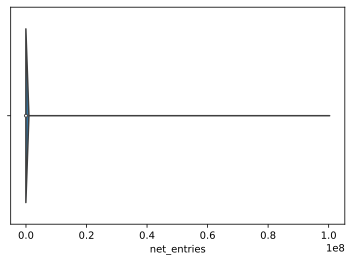

In [19]:
sns.violinplot(x=df.net_entries);

In [20]:
q = np.nanquantile(df["net_entries"], .95)
df = df[df["net_entries"] < q]

q2 = np.nanquantile(df["net_exits"], .95)
df = df[df["net_exits"] < q2]

q3 = np.nanquantile(df['net_traffic'], .95)
df=df[df['net_traffic'] < q3]

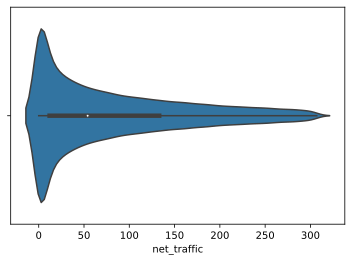

In [22]:
sns.violinplot(data=df, x='net_traffic');

In [25]:
df.head(20)

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time,net_entries,net_exits,net_traffic
unique_id,,,,,,,,,,,,,,,
A002_R051_02_00_00_59_ST_12_18_2021_07_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,07_00_00,REGULAR,7672969,2645040,2021-12-18 07:00:00,3.0,17.0,20.0
A002_R051_02_00_00_59_ST_12_18_2021_11_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,11_00_00,REGULAR,7672991,2645127,2021-12-18 11:00:00,22.0,87.0,109.0
A002_R051_02_00_00_59_ST_12_18_2021_15_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,15_00_00,REGULAR,7673037,2645193,2021-12-18 15:00:00,46.0,66.0,112.0
A002_R051_02_00_00_59_ST_12_18_2021_19_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,19_00_00,REGULAR,7673097,2645270,2021-12-18 19:00:00,60.0,77.0,137.0
A002_R051_02_00_00_59_ST_12_18_2021_23_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,23_00_00,REGULAR,7673128,2645283,2021-12-18 23:00:00,31.0,13.0,44.0
A002_R051_02_00_00_59_ST_12_19_2021_03_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,03_00_00,REGULAR,7673141,2645289,2021-12-19 03:00:00,13.0,6.0,19.0
A002_R051_02_00_00_59_ST_12_19_2021_07_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,07_00_00,REGULAR,7673146,2645299,2021-12-19 07:00:00,5.0,10.0,15.0
A002_R051_02_00_00_59_ST_12_19_2021_11_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,11_00_00,REGULAR,7673153,2645360,2021-12-19 11:00:00,7.0,61.0,68.0
A002_R051_02_00_00_59_ST_12_19_2021_15_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,15_00_00,REGULAR,7673179,2645407,2021-12-19 15:00:00,26.0,47.0,73.0


In [26]:
df.net_entries.isna().sum()

0

In [27]:
df['audit_length_hours'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['date_time'].transform(lambda x: x.diff())

In [28]:
df['audit_length_hours'] = df.audit_length_hours.dt.total_seconds() / 3600

In [29]:
df.audit_length_hours.value_counts()

 4.000000      174862
 4.200000       10567
 8.000000        6905
 16.000000       3544
 12.000000       2608
                ...  
 25.200000          1
 4.032222           1
 4.134444           1
 4.084167           1
-200.000000         1
Name: audit_length_hours, Length: 291, dtype: int64

In [30]:
df.head(20)

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time,net_entries,net_exits,net_traffic,audit_length_hours
unique_id,,,,,,,,,,,,,,,,
A002_R051_02_00_00_59_ST_12_18_2021_07_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,07_00_00,REGULAR,7672969,2645040,2021-12-18 07:00:00,3.0,17.0,20.0,NaN
A002_R051_02_00_00_59_ST_12_18_2021_11_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,11_00_00,REGULAR,7672991,2645127,2021-12-18 11:00:00,22.0,87.0,109.0,4.0
A002_R051_02_00_00_59_ST_12_18_2021_15_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,15_00_00,REGULAR,7673037,2645193,2021-12-18 15:00:00,46.0,66.0,112.0,4.0
A002_R051_02_00_00_59_ST_12_18_2021_19_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,19_00_00,REGULAR,7673097,2645270,2021-12-18 19:00:00,60.0,77.0,137.0,4.0
A002_R051_02_00_00_59_ST_12_18_2021_23_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,23_00_00,REGULAR,7673128,2645283,2021-12-18 23:00:00,31.0,13.0,44.0,4.0
A002_R051_02_00_00_59_ST_12_19_2021_03_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,03_00_00,REGULAR,7673141,2645289,2021-12-19 03:00:00,13.0,6.0,19.0,4.0
A002_R051_02_00_00_59_ST_12_19_2021_07_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,07_00_00,REGULAR,7673146,2645299,2021-12-19 07:00:00,5.0,10.0,15.0,4.0
A002_R051_02_00_00_59_ST_12_19_2021_11_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,11_00_00,REGULAR,7673153,2645360,2021-12-19 11:00:00,7.0,61.0,68.0,4.0
A002_R051_02_00_00_59_ST_12_19_2021_15_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_19_2021,15_00_00,REGULAR,7673179,2645407,2021-12-19 15:00:00,26.0,47.0,73.0,4.0


In [31]:
df.dtypes

control_area                   object
unit                           object
subunit_channel_pos            object
station                        object
subway_lines                   object
division                       object
date                           object
time                           object
desc                           object
entries                         int64
exits                           int64
date_time              datetime64[ns]
net_entries                   float64
net_exits                     float64
net_traffic                   float64
audit_length_hours            float64
dtype: object

In [32]:
df['day_of_week'] = df.date_time.dt.dayofweek

In [33]:
df['pct_change'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['net_traffic'].transform(lambda x: x.pct_change())
df['pct_change'] = df['pct_change'].astype(float).map("{:.2%}".format)



In [34]:
df.head()

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time,net_entries,net_exits,net_traffic,audit_length_hours,day_of_week,pct_change
unique_id,,,,,,,,,,,,,,,,,,
A002_R051_02_00_00_59_ST_12_18_2021_07_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,07_00_00,REGULAR,7672969,2645040,2021-12-18 07:00:00,3.0,17.0,20.0,NaN,5,nan%
A002_R051_02_00_00_59_ST_12_18_2021_11_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,11_00_00,REGULAR,7672991,2645127,2021-12-18 11:00:00,22.0,87.0,109.0,4.0,5,445.00%
A002_R051_02_00_00_59_ST_12_18_2021_15_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,15_00_00,REGULAR,7673037,2645193,2021-12-18 15:00:00,46.0,66.0,112.0,4.0,5,2.75%
A002_R051_02_00_00_59_ST_12_18_2021_19_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,19_00_00,REGULAR,7673097,2645270,2021-12-18 19:00:00,60.0,77.0,137.0,4.0,5,22.32%
A002_R051_02_00_00_59_ST_12_18_2021_23_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,23_00_00,REGULAR,7673128,2645283,2021-12-18 23:00:00,31.0,13.0,44.0,4.0,5,-67.88%


In [35]:
df = df.drop(labels=['control_area', 'unit', 'subunit_channel_pos', 'division', 'desc'], axis=1)

In [36]:
df.head()

,station,subway_lines,date,time,entries,exits,date_time,net_entries,net_exits,net_traffic,audit_length_hours,day_of_week,pct_change
unique_id,,,,,,,,,,,,,
A002_R051_02_00_00_59_ST_12_18_2021_07_00_00_REGULAR,59_ST,NQR456W,12_18_2021,07_00_00,7672969,2645040,2021-12-18 07:00:00,3.0,17.0,20.0,NaN,5,nan%
A002_R051_02_00_00_59_ST_12_18_2021_11_00_00_REGULAR,59_ST,NQR456W,12_18_2021,11_00_00,7672991,2645127,2021-12-18 11:00:00,22.0,87.0,109.0,4.0,5,445.00%
A002_R051_02_00_00_59_ST_12_18_2021_15_00_00_REGULAR,59_ST,NQR456W,12_18_2021,15_00_00,7673037,2645193,2021-12-18 15:00:00,46.0,66.0,112.0,4.0,5,2.75%
A002_R051_02_00_00_59_ST_12_18_2021_19_00_00_REGULAR,59_ST,NQR456W,12_18_2021,19_00_00,7673097,2645270,2021-12-18 19:00:00,60.0,77.0,137.0,4.0,5,22.32%
A002_R051_02_00_00_59_ST_12_18_2021_23_00_00_REGULAR,59_ST,NQR456W,12_18_2021,23_00_00,7673128,2645283,2021-12-18 23:00:00,31.0,13.0,44.0,4.0,5,-67.88%


In [37]:
df.net_entries.isna().sum()

0

In [40]:
hourly_df = df.groupby(pd.Grouper(key='date_time', freq='H'))[['net_traffic']].mean()
hourly_df['pct_change'] = hourly_df.net_traffic.pct_change()
hourly_df

,net_traffic,pct_change
date_time,,
2021-12-11 00:00:00,48.170732,NaN
2021-12-11 01:00:00,69.000000,0.432405
2021-12-11 02:00:00,29.250000,-0.576087
2021-12-11 03:00:00,55.551020,0.899180
2021-12-11 04:00:00,30.083799,-0.458447
...,...,...
2021-12-24 19:00:00,116.487651,0.309410
2021-12-24 20:00:00,104.860269,-0.099816
2021-12-24 21:00:00,83.085427,-0.207656


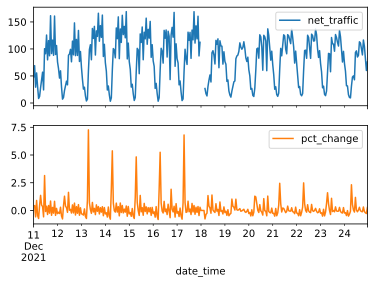

In [41]:
hourly_df.plot(subplots=True);

In [44]:
daily_df = df.groupby(df.day_of_week)[['net_traffic']].sum()
daily_df['pct_change'] = daily_df.net_traffic.pct_change()
daily_df['pct_change'].iloc[0] = ((daily_df.net_traffic.iloc[0] - daily_df.net_traffic.iloc[6]) / daily_df.net_traffic.iloc[6])
daily_df

,net_traffic,pct_change
day_of_week,,
0,2493322.0,0.069115
1,2545820.0,0.021055
2,2566322.0,0.008053
3,2595187.0,0.011248
4,2427962.0,-0.064437
5,2105269.0,-0.132907
6,2332137.0,0.107762


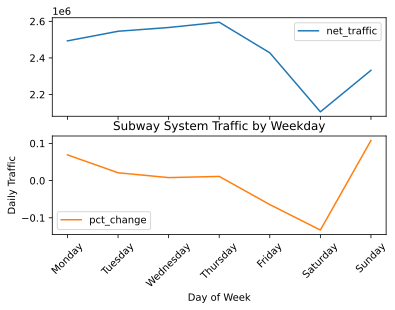

In [46]:
daily_df.plot(subplots=True);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.xlabel('Day of Week');
plt.ylabel('Daily Traffic');
plt.title('Subway System Traffic by Weekday');


In [48]:
station_daily = df.groupby(["station", pd.Grouper(key='date_time', freq='D')])[['net_traffic', 'date_time']].sum().sort_values(by=['station']).reset_index()
station_daily

,station,date_time,net_traffic
0,103_ST,2021-12-18,7594.0
1,103_ST,2021-12-19,9775.0
2,103_ST,2021-12-20,7384.0
3,103_ST,2021-12-21,9178.0
4,103_ST,2021-12-22,7911.0
...,...,...,...
3267,ZEREGA_AV,2021-12-23,2559.0
3268,ZEREGA_AV,2021-12-19,1213.0
3269,ZEREGA_AV,2021-12-18,1329.0
3270,ZEREGA_AV,2021-12-20,2476.0


In [49]:
station_daily['day_of_week'] = station_daily.date_time.dt.dayofweek

In [50]:
station_daily['pct_change'] = station_daily.groupby(['station'])['net_traffic'].apply(lambda x: x.pct_change())

In [51]:
station_daily

,station,date_time,net_traffic,day_of_week,pct_change
0,103_ST,2021-12-18,7594.0,5,NaN
1,103_ST,2021-12-19,9775.0,6,0.287200
2,103_ST,2021-12-20,7384.0,0,-0.244604
3,103_ST,2021-12-21,9178.0,1,0.242958
4,103_ST,2021-12-22,7911.0,2,-0.138048
...,...,...,...,...,...
3267,ZEREGA_AV,2021-12-23,2559.0,3,0.000391
3268,ZEREGA_AV,2021-12-19,1213.0,6,-0.525987
3269,ZEREGA_AV,2021-12-18,1329.0,5,0.095631
3270,ZEREGA_AV,2021-12-20,2476.0,0,0.863055


In [54]:
station_daily['pct_change'] = station_daily['pct_change'].astype(float).map("{:.2%}".format)

In [55]:
#new_df = old_df.groupby(['column1', 'column2']).agg({'column1':'first','column2':'first', 'column3':'mean', 'column4':'sum'})
station_daily

,station,date_time,net_traffic,day_of_week,pct_change
0,103_ST,2021-12-18,7594.0,5,nan%
1,103_ST,2021-12-19,9775.0,6,28.72%
2,103_ST,2021-12-20,7384.0,0,-24.46%
3,103_ST,2021-12-21,9178.0,1,24.30%
4,103_ST,2021-12-22,7911.0,2,-13.80%
...,...,...,...,...,...
3267,ZEREGA_AV,2021-12-23,2559.0,3,0.04%
3268,ZEREGA_AV,2021-12-19,1213.0,6,-52.60%
3269,ZEREGA_AV,2021-12-18,1329.0,5,9.56%
3270,ZEREGA_AV,2021-12-20,2476.0,0,86.31%


In [59]:
station_monthly = station_daily.groupby(['station', pd.Grouper(key='date_time', freq='BM')])[['net_traffic']].sum().sort_values(by = 'net_traffic', ascending=False).reset_index()
station_monthly

,station,date_time,net_traffic
0,34_ST_PENN_STA,2021-12-31,340382.0
1,FULTON_ST,2021-12-31,292076.0
2,23_ST,2021-12-31,290580.0
3,59_ST,2021-12-31,264418.0
4,GRD_CNTRL_42_ST,2021-12-31,234350.0
...,...,...,...
372,AQUEDUCT_RACETR,2021-12-31,3869.0
373,BEACH_98_ST,2021-12-31,2804.0
374,TOMPKINSVILLE,2021-12-31,2108.0
375,BROAD_CHANNEL,2021-12-31,1064.0


In [ ]:
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

In [60]:
df.station.nunique()

377

In [69]:
top_stations = df.groupby('station')[['net_traffic']].sum().sort_values(by='net_traffic', ascending=False)
top_stations['pct_total'] = top_stations['net_traffic'].apply(lambda x: x / top_stations.net_traffic.sum())
top_stations.head(20)

,net_traffic,pct_total
station,,
34_ST_PENN_STA,340382.0,0.019945
FULTON_ST,292076.0,0.017114
23_ST,290580.0,0.017027
59_ST,264418.0,0.015494
GRD_CNTRL_42_ST,234350.0,0.013732
86_ST,233497.0,0.013682
CANAL_ST,230765.0,0.013522
34_ST_HERALD_SQ,186363.0,0.010920
49_ST,177857.0,0.010422


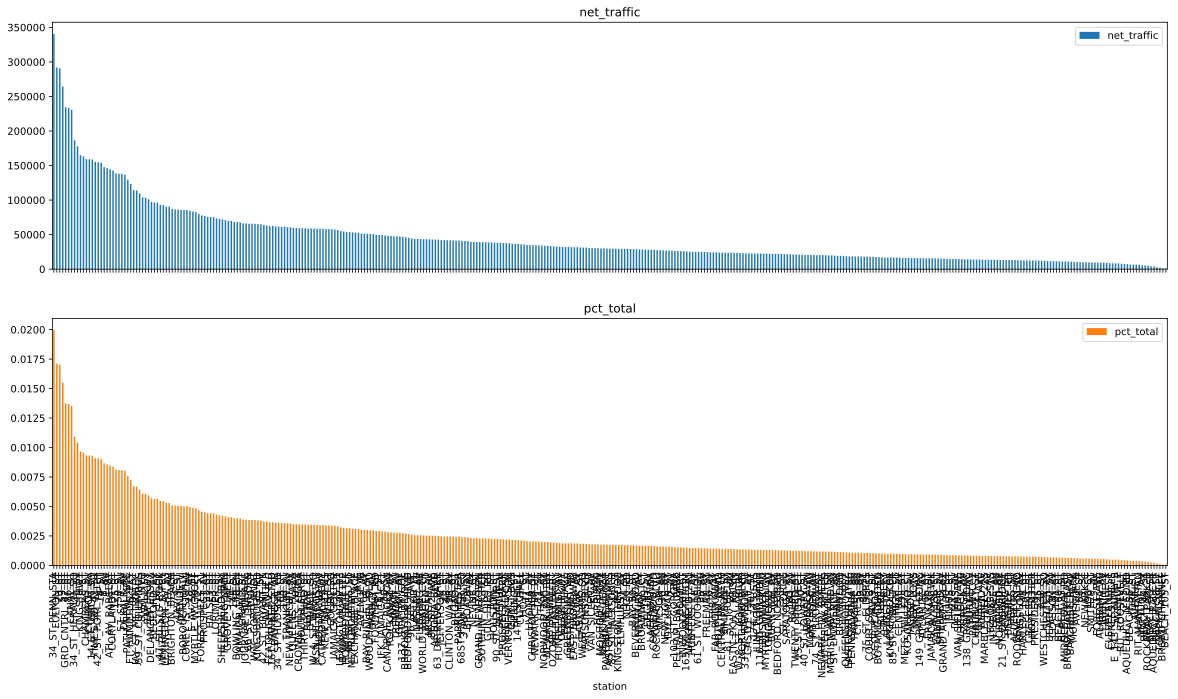

In [85]:
top_stations.plot(subplots=True, kind='bar',figsize=(20,10));

In [ ]:
nta_map = gpd.read_file('/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/nynta2020.shp')
nta_map.head()
nta_map.to_crs(4326, inplace=True)
nta_map.crs

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
nta_map.plot(ax=ax);

In [ ]:
station_df = gpd.read_file('Subway Stations.geojson')
len(station_df)

In [ ]:
df.station.value_counts()

In [ ]:
station_df.name = station_df.name.str.replace(' - ', '_')
station_df.name = station_df.name.str.replace(' ', '_')
station_df.name = station_df.name.str.replace('(', '')
station_df.name = station_df.name.str.replace(')', '')
station_df.name = station_df.name.str.replace('/', '')
station_df.name = station_df.name.str.replace('', '')
station_df

In [ ]:
station_df.to_crs(4326, inplace=True)

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
station_df.plot(ax=ax, markersize=20, color='blue', marker='o', label = 'Station')

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.plot(ax=ax);
station_df.plot(ax=ax, markersize=20, color='red', marker='o', label = 'Station');